Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [775]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import lab9_lib
import sys
import math

from tqdm import tqdm
from dataclasses import dataclass
from copy import deepcopy
from collections import deque

## Numeric Values

In [776]:
INSTANCES = [1, 2, 5, 10] 
LOCI_GENOMES = 1000 # the lenght of the genotype
POPULATION_SIZE = 200 # the size of the entire population
TOURNAMENT_SIZE = 5 # the amount of individuals the selection of the parents will me made on
OFFSPRINGS = 20 # amount of offsprings per each generation
MAX_GENERATIONS = 3000 # numebr of generations at most (unless we find an optimum before)
# N_CUT_XOVER_PROB = .8
MAX_CUT_POINTS = 10 # maximum number of cutting points in a xover (they're random)
# MIN_CUT_POINTS = 2
# TABU_LENGHT = 8196*4 # ~4kb # tabu table size
# MUTATION_PROBABILITY = .8
# XOVER_PROBABILITY = .5 # probability of chosing n_cut_xover rather than one_cut_xover
THRESHOLD_IMPROVEMENT = 1e-3
DELTA_GENERATIONS = 3000 # after how many generations the delta between fitnesses is computed
# SCALING_FACTOR_PROB = .8
ISLANDS = 1 # number of islands
MAX_POPULATION_ISLAND = int(POPULATION_SIZE/ISLANDS)
MIGRATION_RATE = 100 # after how many generations we have a migration
MIGRANTS = 10 # number of migrants
TEMPERATURE = 1e-2
SIMULATED_ANEALING_DURATION = 250 # how many generations simulated anealing last

## Evolutionary Strategy Functions

In [777]:
@dataclass
class Individual:
    genotype: list[bool]
    fitness: float

    def __str__(self):
        return f"{self.genotype}: {self.fitness:.2%}"

    def fitness(self) -> float:
        return fitness

def mutation(ind: Individual) -> None:
    # strength =  math.ceil((LOCI_GENOMES - sum(ind.genotype)) / 20) # number of zeros / 20
    genes = rnd.sample([i for i in range(LOCI_GENOMES)], 1)
    
    for g in genes:
        ind.genotype[g] = 1 - ind.genotype[g] 

    # gene = rnd.choice([i for i in range(LOCI_GENOMES)])
    # ind.genotype[gene] = 1 - ind.genotype[gene] 
    # ind.fitness = None

def one_cut_xover(ind1: Individual, ind2: Individual) -> Individual:
    cut_point = int(len(ind1.genotype) / 2)
    offspring = Individual(genotype=np.concatenate((ind1.genotype[:cut_point], ind2.genotype[cut_point:]), axis=None), fitness=None)
    return offspring

def n_cut_xover(ind1: Individual, ind2: Individual, cuts: int) -> Individual:
    cut_points = np.linspace(0, LOCI_GENOMES, cuts + 1, dtype=int)
    inds = (ind1, ind2)
    ind_turn = 0
    prev_cut_point = 0
    offspring = Individual(genotype=np.zeros(LOCI_GENOMES), fitness=None)

    for cut in cut_points:
        offspring.genotype[prev_cut_point:cut] = inds[ind_turn].genotype[prev_cut_point:cut]
        prev_cut_point = cut
        ind_turn = 1 - ind_turn

    assert len(offspring.genotype) == LOCI_GENOMES

    return offspring

def select_parent(population: list) -> Individual:
    pool = [rnd.choice(population) for _ in range(TOURNAMENT_SIZE)]
    champion = max(pool, key=lambda i: i.fitness)
    return champion

## Tabu Table

In [778]:
# Tabu table will remember if a recent state was already been anlized
# When the table is full it removes the oldest state that was analized
# The dimension of the table is a cruicial and though parameter to decide

@dataclass
class TabuCache:
    table: deque

    def __init__(self, size) -> None:
        self.table = deque(maxlen=size)

    def tabu_add(self, state: list) -> bool:
        try:
            hit = False
            if self.table.index(state) >= 0:
                self.table.remove(state)
                hit = True
        except ValueError:
            pass
        finally:
            self.table.append(state)
        
        return hit

    def get_table(self) -> deque:
        return self.table


## Population Generation

In [779]:
def generate_population(instance: int, fitness: list) -> (list):
    population = list()
    genotypes = list()

    # generate different individuals
    for i in range(POPULATION_SIZE):
        new_genotype = rnd.choices([0, 1], k=LOCI_GENOMES)
        while new_genotype in genotypes:
            new_genotype = rnd.choices([0, 1], k=LOCI_GENOMES)

        genotypes.append(new_genotype)
        population.append(Individual(genotype=new_genotype, fitness=None))
        
    for i in population:
        i.fitness = fitness[instance](i.genotype)

    return population


## Divide in Islands

In [780]:
# We should divide the starting population into different islands
# representing different isolated environments.
# Migrations are allowd sporadically

def generate_islands(population: list) -> list:
    islands = list()
    slice_points = np.linspace(0, POPULATION_SIZE, ISLANDS + 1, dtype=int)

    for isl in range(ISLANDS):
        islands.append(population[slice_points[isl]:slice_points[isl+1]])

    return islands

## Simulated Annealing

In [781]:
def prob(f1: float, f2: float, temp: float):
    return np.exp(-(f1-f2)/temp)

## Training

Solving for instance: 1


  0%|          | 0/3000 [00:00<?, ?it/s]

 46%|████▋     | 1389/3000 [00:04<00:05, 298.92it/s]


Reached fitness maximum before 3000 generations!
Number of fitness calls for instance 1: 28000
Solving for instance: 2


100%|██████████| 3000/3000 [00:12<00:00, 244.37it/s]


Number of fitness calls for instance 2: 60200
Solving for instance: 5


100%|██████████| 3000/3000 [00:10<00:00, 278.79it/s]


Number of fitness calls for instance 5: 60200
Solving for instance: 10


  7%|▋         | 210/3000 [00:00<00:11, 250.85it/s]


KeyboardInterrupt: 

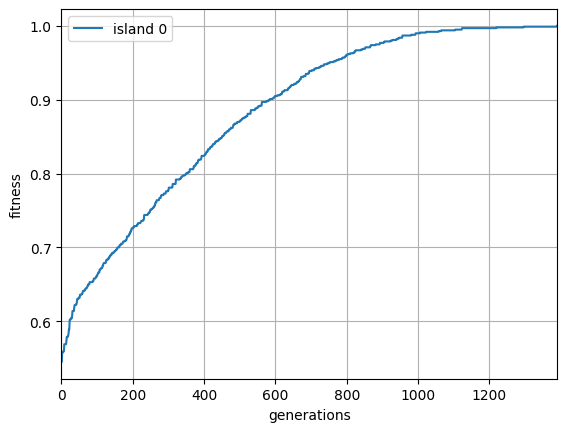

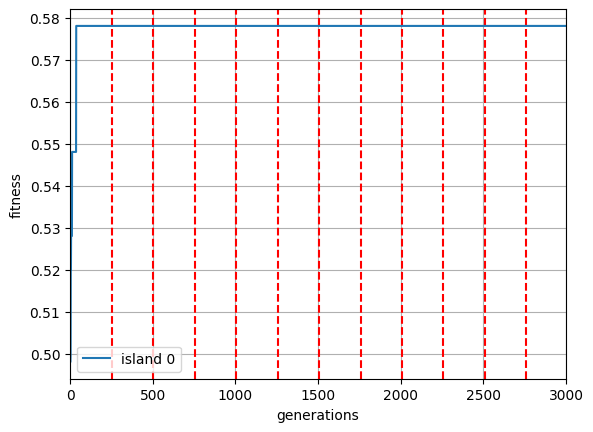

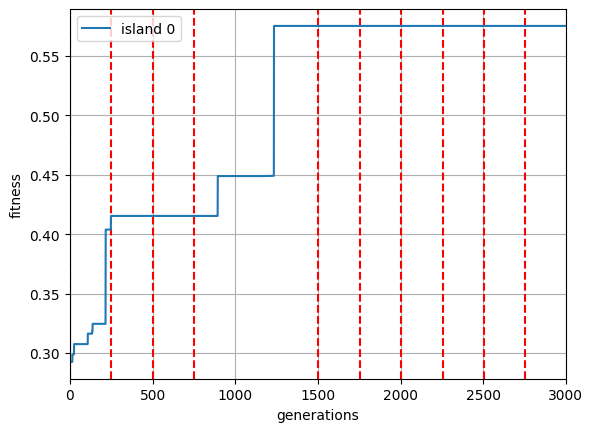

In [782]:
population = None
islands = None
islands_popultaion = [MAX_POPULATION_ISLAND for _ in range(ISLANDS)]
fitness =  [lab9_lib.make_problem(i) for i in INSTANCES]
prev_best_fitness = 0
delta_improv_fitness = sys.maxsize 
simulated_anealing = None
start_sim_aneal = 0
# mutation_probability = MUTATION_PROBABILITY
# xover_probability = XOVER_PROBABILITY
# n_cut_points = MIN_CUT_POINTS

# for the graphs
x = np.linspace(0, MAX_GENERATIONS, MAX_GENERATIONS)
y = [np.zeros(MAX_GENERATIONS) for _ in range(ISLANDS)]
stop = None

for idx, inst in enumerate(INSTANCES):
    print(f"Solving for instance: {inst}")

    # for plotting
    stop = MAX_GENERATIONS

    # generate population for new problem instances
    population = generate_population(idx, fitness)
    islands = generate_islands(population)
    simulated_anealing = False
    activation_sim_aneal = list()
    # tabu = TabuCache(size=TABU_LENGHT)
    # hit_count = 0

    for gen in tqdm(range(MAX_GENERATIONS)):
        
        # migrations
        if gen != 0 and gen % MIGRATION_RATE == 0:
            migrants = []
            for isl in range(ISLANDS):
                migrants.append(islands[isl][:MIGRANTS])

            # circular migration
            for isl in range(ISLANDS):
                if isl == ISLANDS- 1:
                    islands[0][:MIGRANTS] = migrants[isl]
                else:
                    islands[isl + 1][:MIGRANTS] = migrants[isl]
        
        for isl in range(ISLANDS):
            offsprings = list()

            for _ in range(OFFSPRINGS):
                # hit = True
                # while hit:
                p1 = select_parent(islands[isl])

                # if we're dealing with simulated anealing we have to select a parent from the worse individuals
                if len(islands[isl]) > MAX_POPULATION_ISLAND:
                    p2 = rnd.choice(islands[isl])
                else:
                    p2 = select_parent(islands[isl])
                
                o = n_cut_xover(p1, p2, rnd.choice([k for k in range(2, MAX_CUT_POINTS)]))
                mutation(o)
                    
                # hit = tabu.tabu_add(o.genotype)
                # if hit:
                #     hit_count += 1

                offsprings.append(o)

            for o in offsprings:
                o.fitness = fitness[idx](o.genotype)
                # o.fitness = fitness[idx].onemax(o.genotype) / LOCI_GENOMES

            if gen - start_sim_aneal > SIMULATED_ANEALING_DURATION:
                simulated_anealing = False
                islands_popultaion[isl] = MAX_POPULATION_ISLAND

            if simulated_anealing == False and delta_improv_fitness < THRESHOLD_IMPROVEMENT:
                activation_sim_aneal.append(gen)
                simulated_anealing = True
                start_sim_aneal = gen
            
            islands[isl].extend(offsprings)
            islands[isl].sort(key=lambda i: i.fitness, reverse=True)

            if simulated_anealing:
                discarded = islands[isl][islands_popultaion[isl]:]

            islands[isl] = islands[isl][:islands_popultaion[isl]]
            worst = islands[isl][-1]

            # simulated anealing : keep some worse offspring
            if simulated_anealing:
                for d in discarded:
                    wf = worst.fitness
                    df = d.fitness
                    if wf != df and rnd.random() < prob(wf, df, TEMPERATURE):
                        islands[isl].append(d)
                        islands_popultaion[isl] += 1

            # print(len(islands[isl]))

            if islands[isl][0].fitness == 1:
                stop = gen + 1

            # updating graph
            y[isl][gen] = islands[isl][0].fitness

            # every 10 generations:
            # update delta of fitness between gen_i and gen_i+1
            # save fitness of this generation
            if gen != 0 and gen % DELTA_GENERATIONS == 0:
                delta_improv_fitness = islands[isl][0].fitness - prev_best_fitness
                prev_best_fitness = islands[isl][0].fitness

            # accept worse individuals since we are in a local optimum 

            # if threshold_improvement > 1/OFFSPRINGS and delta < threshold_improvement:
            #     n_cut_points *= 2 
            #     if n_cut_points > MAX_CUT_POINTS:
            #         n_cut_points = MAX_CUT_POINTS
            #     threshold_improvement *= .1
            #     xover_probability *= SCALING_FACTOR_PROB
            #     mutation_prbability = 1 - xover_probability

        if stop != MAX_GENERATIONS:
            print(f"Reached fitness maximum before {MAX_GENERATIONS} generations!")
            break
    
    print(f"Number of fitness calls for instance {inst}: {fitness[idx].calls}")
    # print(f"Population of island at the end: {islands_popultaion[isl]}")
    # print(f"Tabu table hit {hit_count} times!")
    plt.figure()
    plt.grid()
    plt.xlabel('generations')
    plt.ylabel('fitness')
    plt.xlim(-0.5, stop + 0.5)

    for line_x in activation_sim_aneal:
        plt.axvline(x = line_x, color = 'r', ls="--")

    for isl in range(ISLANDS):
        plt.plot(x[:stop], y[isl][:stop], label=f"island {isl}")

    plt.legend()
    plt.savefig(f"instance{inst}.png")
